In [1]:
import torch 
import seaborn as sns
from circuitsvis.attention import attention_heads, attention_patterns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import os
import time
import concurrent.futures
import gc
import json 

In [2]:
# Global settings
torch.set_grad_enabled(False) #to disable gradients -> faster computiations
# Ensure GPU acceleration is enabled on Mac
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
mod = None
tokenizer = None
META_LLAMA_3_2_3B = "meta-llama/Llama-3.2-3B"
GOOGLE_GEMMA_2_2B = "google/gemma-2-2b"
dataset = {}
CSV_PATH_DATASET = "dataset/examples.csv"

In [3]:
models = [GOOGLE_GEMMA_2_2B, META_LLAMA_3_2_3B] 

### Functions

In [4]:
def initialize_model(model_name: str, tokenizer_name: str = None):
    if not tokenizer_name:
        tokenizer_name = model_name
    # Initialize model and tokenizer
    global model
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16)
    if not tokenizer_name:
        tokenizer_name = model_name
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


In [5]:
def load_dataset(path_to_csv: str):
    # Check if the file at the given path exists
    if os.path.exists(path_to_csv):
        df = pd.read_csv(path_to_csv)
    else:
        print("File does not exist.")
        exit(1)

    global dataset 
    dataset = df
    
    # Create a new column "token_probability" for saving up the probabilites of the studied token for all prompts. Initially, 0.
    dataset["token_probability_true_sentence"] = 0
    dataset["token_probability_false_sentence"] = 0

In [6]:
def print_colored_separator(color="\033[94m", char="=", length=150, prints_enabled: bool = False):
    if prints_enabled:
        reset = "\033[0m"  # Reset color
        print(f"{color}{char * length}{reset}")

In [7]:
# Returns the model's output after feeding it with a prompt concatenated prompt_repetitions times and the concatenated prompt tensor
def feed_forward(prompt: str, prompt_repetitions: int = 1, prints_enabled: bool = False):
    print_colored_separator(prints_enabled)
    token_sequence = tokenizer(prompt, return_tensors="pt")
    tokens = token_sequence["input_ids"][0]
    
    sentence_to_concatenate = tokens
    for _ in range(prompt_repetitions):
        sentence_to_concatenate = torch.concat([sentence_to_concatenate, tokens[1:]])

    if prints_enabled:
        print(f"Input: {prompt}\n")
        print(f"Tokenizer tokens: {tokens}\n")
        print("Concatenated prompt:")
        print(f"{tokenizer.decode(sentence_to_concatenate)}\n")
        print("Concatenated tokens:")
        print(f"{sentence_to_concatenate}\n")

    # Feed forward to the model
    global model
    out = model(sentence_to_concatenate.unsqueeze(0).to(model.device), return_dict=True, output_attentions=True)
    return out, sentence_to_concatenate

In [8]:
def create_attention_mask(token_sequence: str, show_induction_mask: bool = False, prints_enabled: bool = False):
    print_colored_separator(prints_enabled)
    sequence_length = len(token_sequence)
    half_of_sequence = sequence_length // 2 - 1
    induction_mask = torch.zeros(sequence_length, sequence_length).to(float)

    for i in range(sequence_length // 2 + 1, sequence_length):
        induction_mask[i, i - half_of_sequence] = 1 
    
    if show_induction_mask:
        print("Induction Mask:\n")
        print(induction_mask)
        print()
        print("Induction Mask plot:\n")
        plt.imshow(induction_mask)
        plt.show()
        print()
    return induction_mask

In [9]:
def compute_induction_head_scores(token_sequence: str, induction_mask: torch.Tensor, model_output):
    num_heads = model.config.num_attention_heads
    num_layers = model.config.num_hidden_layers
    sequence_length = len(token_sequence)

    induction_scores = torch.zeros(num_layers, num_heads)
    tril = torch.tril_indices(sequence_length - 1, sequence_length - 1) # gets the indices of elements on and below the diagonal
    induction_flat = induction_mask[tril[0], tril[1]].flatten()
    
    for layer in range(num_layers):
        for head in range(num_heads):
            pattern = model_output["attentions"][layer][0][head].cpu().to(float)[1:, 1:]
            pattern_flat = pattern[tril[0], tril[1]].flatten()
            score = (induction_flat @ pattern_flat) / pattern_flat.sum()
            induction_scores[layer, head] = score
    return induction_scores

In [10]:
def create_heatmap(induction_scores: torch.Tensor):
    print_colored_separator()
    _, ax = plt.subplots()
    print("Heatmap of induction scores across heads and layers: \n")
    sns.heatmap(induction_scores, cbar_kws={"label": "Induction Head Score"}, ax=ax)
    ax.set_ylabel("Layer #")
    ax.set_xlabel("Head #")
    plt.show()

In [11]:
def sort_filter_high_scoring_induction_heads(induction_scores: torch.Tensor, model_output: any, filter_by_threshold: float = 0.5, show_induction_heads: bool = False, prints_enabled: bool = False): 
    print_colored_separator(prints_enabled)
    
    # Filter induction scores by threshold
    mask = induction_scores >= filter_by_threshold

    filtered_scores = torch.where(mask, induction_scores, torch.tensor(float('-inf')))

    # Get flattened indices sorted by scores in descending order
    sorted_flat_indices = torch.argsort(filtered_scores.flatten(), descending=True)

    valid_indices = sorted_flat_indices[filtered_scores.flatten()[sorted_flat_indices] != float('-inf')]

    # Convert flattened indices to 2D indices
    sorted_indices = torch.unravel_index(valid_indices, induction_scores.shape)

    # Stack the row and column indices for final output
    sorted_indices = torch.stack(sorted_indices, dim=1)

    if show_induction_heads:
        print("Top 5 Induction Heads with the highest induction score - Descending order\n")
        for layer, head in sorted_indices[:5]:
            print(f"Layer: {layer}\nHead: {head}")
            plt.imshow(model_output["attentions"][layer][0][head].cpu().float())
            plt.show()
            print()
    return sorted_indices

In [12]:
def token_probability_extraction(head_indices: torch.Tensor, models_output: any, prints_enabled: bool = False):
    data = {}
    for idx in head_indices:
        print_colored_separator(prints_enabled)
        layer, head = idx
        probs = models_output["attentions"][layer][0][head]

        # Extract probability of the specified token
        sequence_length = probs.shape[0]
        probability_token = probs[sequence_length - 2, sequence_length // 2].item() * 100
        data[f"L{layer}_H{head}"] = probability_token

        if prints_enabled:
            print(f"Probability of token at layer {layer} and head {head}: ", probability_token)
    return json.dumps(data)


In [13]:
def save_probability(token_probability: int, example_id: int, column_name_probability: str, prints_enabled: bool = False):
    if dataset.empty:
        raise Exception("Dataset is empty")
    
    print_colored_separator(prints_enabled)
    # Log the probability of the token into its corresponding row and column in the dataset.
    dataset.loc[dataset["example_id"] == example_id, f"{column_name_probability}"] = token_probability 
    if prints_enabled:
        print(f"Saved probability for token from example_id: {example_id}\n")

In [14]:
def display_attention_visualizations(head_indices: torch.Tensor, token_sequence: torch.Tensor, models_output):
    # Display attention diagrams
    tokens_vis = tokenizer.tokenize(tokenizer.decode(token_sequence.squeeze()))
    layer, head = head_indices[0]
    return attention_patterns(tokens_vis, models_output["attentions"][layer][0]), attention_heads(models_output["attentions"][layer][0], tokens_vis)

In [15]:
def run_experiment(prompt: str, prompt_repetitions: int = 1, filter_by_threshold: float = 0.5):
    models_output, token_sequence = feed_forward(prompt=prompt, prompt_repetitions=prompt_repetitions)
    induction_mask = create_attention_mask(token_sequence=token_sequence)
    induction_scores = compute_induction_head_scores(token_sequence=token_sequence, induction_mask=induction_mask, model_output=models_output)

    # create_heatmap(induction_scores=induction_scores)
    
    # Get induction heads indices after filtering by a threshold and sort them descending from top scoring head
    indices_induction_heads = sort_filter_high_scoring_induction_heads(induction_scores=induction_scores, model_output=models_output, filter_by_threshold=filter_by_threshold)

    # Extract the probability of the studied token for each head and layer. Store it in json format  
    token_probabilities_layer_head = token_probability_extraction(indices_induction_heads, models_output)

    return token_probabilities_layer_head


In [16]:
def save_plot_results(save_path: str):
    # Get the list of heads
    head_sets_true_sentences = dataset["token_probability_true_sentence"].apply(json.loads)
    head_sets_true = head_sets_true_sentences.apply(lambda d: set(d.keys()))

    head_sets_false_sentences = dataset["token_probability_false_sentence"].apply(json.loads)
    head_sets_false = head_sets_false_sentences.apply(lambda d: set(d.keys()))

    # Calculate the intersection
    common_heads_true = set.intersection(*head_sets_true)
    common_heads_false = set.intersection(*head_sets_false)

    # Intersection of the heads which appear in the true && false sentence
    total_intersection_set = set.intersection(common_heads_true, common_heads_false)

    data = []
    for _, row in dataset.iterrows():
        for head in total_intersection_set:
            data.append({"Head": head, "Probability": json.loads(row["token_probability_true_sentence"])[head], "Type": "True"})
            data.append({"Head": head, "Probability": json.loads(row["token_probability_false_sentence"])[head], "Type": "False"})

    plot_df = pd.DataFrame(data=data)
    ax = sns.boxplot(data=plot_df, x="Head", y="Probability", hue="Type")
    ax.get_figure().savefig(f"{save_path}-results-plot.png", dpi=300)


In [17]:
def save_result_csv(model_name: str, dataset_csv_file_path: str, dataset):
    model_name_folder = model_name.split("/")
    folder_path = os.path.dirname(dataset_csv_file_path) + "/" + model_name_folder[0] 
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    model_and_path = f"{model_name_folder[-1]}-results.csv"
    new_file_path = os.path.join(folder_path, model_and_path)
    dataset.to_csv(new_file_path, index=False)

    # Save plot for the current dataset 
    model_and_path_image = os.path.join(folder_path, model_name_folder[-1])
    save_plot_results(save_path=model_and_path_image)

In [18]:
def delete_model():
    global model
    del model
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()  # Clear MPS GPU memory
    


In [19]:
def run_experiment_suite(dataset_csv_file_path: str, llm_models: list, prompt_repetitions: int = 1, filter_by_threshold: int = 0.5):
    for mod in llm_models: 
        print(f"Using device: {torch.device('mps') if torch.backends.mps.is_available() else 'cpu'}")
        initialize_model(model_name=mod, tokenizer_name=mod)
        load_dataset(path_to_csv=dataset_csv_file_path)
        
        # Use ThreadPoolExecutor since multiprocessing won't work well with Metal
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
            future_true = executor.submit(
                lambda: dataset.apply(lambda row: run_experiment(row["true_sentence"], prompt_repetitions=prompt_repetitions, filter_by_threshold=filter_by_threshold), axis=1)
            )
            future_false = executor.submit(
                lambda: dataset.apply(lambda row: run_experiment(row["false_sentence"], prompt_repetitions=prompt_repetitions, filter_by_threshold=filter_by_threshold), axis=1)
            )

            # Collect results
            dataset["token_probability_true_sentence"] = future_true.result()
            dataset["token_probability_false_sentence"] = future_false.result()

        # Create CSV result files saved in folders respective to the used LLM.
        save_result_csv(model_name=mod, dataset_csv_file_path=dataset_csv_file_path, dataset=dataset) 

        # Delete the model loaded in memory
        delete_model()


### Experiment Start

Your current working directory: /Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep
Using device: mps


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Using device: mps


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Starting from v4.46, the `logits` model output will have the same type as the m

Execution Time: 25.2136 seconds.


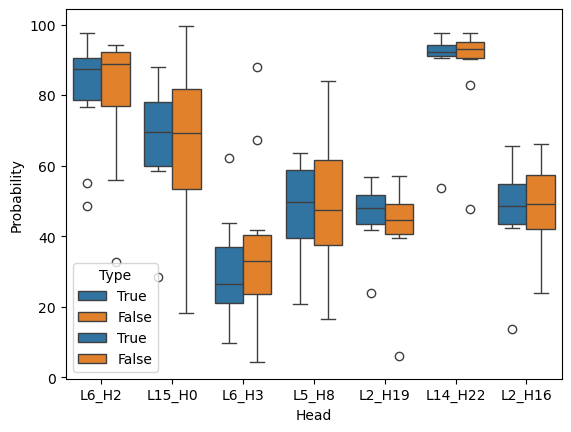

In [20]:
print("Your current working directory:", os.getcwd())
start_time = time.perf_counter()
run_experiment_suite(dataset_csv_file_path=CSV_PATH_DATASET, llm_models=models, prompt_repetitions=1, filter_by_threshold=0.5)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.4f} seconds.")